In [2]:
%matplotlib inline

# Calculate local Moran's I for different empirical maps (maps were downsampled in Matlab to 10k vertices for computational efficiency)

import glob
import h5py
import numpy as np
from brainspace.gradient import GradientMaps
from brainspace.gradient import alignment
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import helpers

import scipy, math
from sklearn.metrics import DistanceMetric
from scipy import special
from neuromaps.datasets import available_annotations
from neuromaps.datasets import fetch_annotation


SurfaceMask=np.loadtxt('surfBilateralMask.txt')
dist_mat_file = "SurfL10kConte.txt"
dist_mat_file_r = "SurfR10kConte.txt"
dist_file=np.loadtxt(dist_mat_file)
dist_file_r=np.loadtxt(dist_mat_file_r)
distMat=dist_file[np.ix_(SurfaceMask[:5000]==1,SurfaceMask[:5000]==1)]

Myelin=np.loadtxt('Myelin10k.txt')
tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]

Thickness=np.loadtxt('Thickness10k.txt')
tempData=Thickness[:5000]
ThicknessReduced=tempData[SurfaceMask[:5000]==1]

def appendSpherical_np(xyz):
# this function turns it from cartesian coordinates (x,y,z) into lontitude and latitude taken from https://pyquestions.com/faster-numpy-cartesian-to-spherical-coordinate-conversion
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:, 0]**2 + xyz[:, 1]**2
    ptsnew[:, 3] = np.sqrt(xy + xyz[:, 2]**2)
    ptsnew[:, 4] = np.arctan2(xyz[:, 2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:, 5] = np.arctan2(xyz[:, 1], xyz[:, 0])
    return ptsnew

def write_plyRGB(filename, vertices, faces, colorsR,colorsG,colorsB,comment=None):
    import pandas as pd
    print("writing ply format")
    # infer number of vertices and faces
    number_vertices = vertices.shape[0]
    number_faces = faces.shape[0]
    # make header dataframe
    header = ['ply',
            'format ascii 1.0',
            'comment %s' % comment,
            'element vertex %i' % number_vertices,
            'property float x',
            'property float y',
            'property float z',
            'property uchar red',
            'property uchar green',
            'property uchar blue',
            'element face %i' % number_faces,
            'property list uchar int vertex_indices',
            'end_header'
             ]
    header_df = pd.DataFrame(header)
    # make dataframe from vertices
    vertex_df = pd.DataFrame(vertices/50)
    #colors_df = pd.DataFrame(np.tile(np.round(colors/7*255), (3,1)).T)
    ColorsR_df=pd.DataFrame(colorsR)
    ColorsG_df=pd.DataFrame(colorsG)
    ColorsB_df=pd.DataFrame(colorsB)
    colorsConcat = pd.concat([ColorsR_df,ColorsG_df,ColorsB_df], axis=1)
    colors_df=pd.DataFrame(colorsConcat)
    colors_df=colorsConcat.astype(int)
    df_concat = pd.concat([vertex_df, colors_df], axis=1)
    # make dataframe from faces, adding first row of 3s (indicating triangles)
    triangles = np.reshape(3 * (np.ones(number_faces)), (number_faces, 1))
    triangles = triangles.astype(int)
    faces = faces.astype(int)
    faces_df = pd.DataFrame(np.concatenate((triangles, faces), axis=1))
    # write dfs to csv
    header_df.to_csv(filename, header=None, index=False)
    with open(filename, 'a') as f:
        df_concat.to_csv(f, header=False, index=False,
                         float_format='%.3f', sep=' ')
    with open(filename, 'a') as f:
        faces_df.to_csv(f, header=False, index=False,
                        float_format='%.0f', sep=' ')

In [4]:
def morans_i(dist, y, normalize=False, local=False, invert_dist=True):
    """
    Calculates Moran's I from distance matrix `dist` and brain map `y`
    Parameters
    ----------
    dist : (N, N) array_like
        Distance matrix between `N` regions / vertices / voxels / whatever
    y : (N,) array_like
        Brain map variable of interest
    normalize : bool, optional
        Whether to normalize rows of distance matrix prior to calculation.
        Default: False
    local : bool, optional
        Whether to calculate local Moran's I instead of global. Default: False
    invert_dist : bool, optional
        Whether to invert the distance matrix to generate a weight matrix.
        Default: True
    Returns
    -------
    i : float
        Moran's I, measure of spatial autocorrelation
    """

    # convert distance matrix to weights
    if invert_dist:
        with np.errstate(divide='ignore'):
            dist = 1 / dist
    np.fill_diagonal(dist, 0)

    # normalize rows, if desired
    if normalize:
        dist /= dist.sum(axis=-1, keepdims=True)

    # calculate Moran's I
    z = y - y.mean()
    if local:
        with np.errstate(all='ignore'):
            z /= y.std()

    zl = np.squeeze(dist @ z[:, None])
    den = (z * z).sum()

    if local:
        return (len(y) - 1) * z * zl / den

    return len(y) / dist.sum() * (z * zl).sum() / den




writing ply format


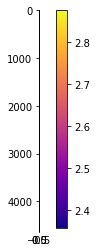

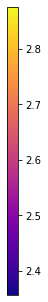

writing ply format


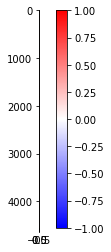

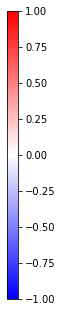

In [8]:


import nibabel as nib
import matplotlib 
gii = nib.load('S900_L_very_inflated_MSMAll_32k_fs_LR_sur_to10k_check.gii')

verts=gii.agg_data()[0].T[SurfaceMask[:5000]==1,:]

vertsFull=gii.agg_data()[0].T
facesFull=gii.agg_data()[1]


dataToDisplay=ThicknessReduced 

# Compute Local Moran's I for each spatial unit
I_values = m_i_myelin=morans_i(distMat, dataToDisplay, normalize=True, local=True, invert_dist=True)

nameToDisplay='Thickness'


cmap = matplotlib.cm.get_cmap('plasma')

colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=dataToDisplay
DataRange=np.array([np.percentile(dataToDisplay,25),np.percentile(dataToDisplay,75)])
norm = matplotlib.colors.Normalize(vmin=DataRange[0], vmax=DataRange[1])
np.savetxt('SpatStatImages/DataRange_'+nameToDisplay+'.txt',DataRange)

CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/'+nameToDisplay + '.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(dataToDisplay.reshape(-1,1), cmap='plasma',vmin=DataRange[0], vmax=DataRange[1])
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/Colorbar' + nameToDisplay+'.png', bbox_inches='tight')

plt.show()


cmap = matplotlib.cm.get_cmap('bwr')
colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=I_values
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/localMI_'+nameToDisplay+'.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(I_values.reshape(-1,1), cmap='bwr',vmin=-1, vmax=1)
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/MoransIColorBar.png', bbox_inches='tight',dpi=600)





writing ply format


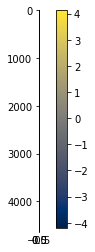

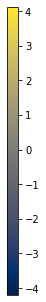

writing ply format


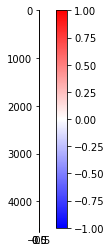

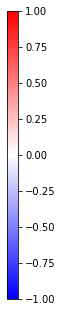

In [10]:
#m_i_myelin=morans_i(distMat, MyelinReduced, normalize=True, local=True, invert_dist=True)



#(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)




#for annotation in available_annotations():
    #test = fetch_annotation(source=annotation)
#    print(annotation)

    
# Myelin


annotation = fetch_annotation(source='margulies2016',hemi='L',den='32k',desc='fcgradient01',return_single=True)

#annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='myelinmap',return_single=True)
annot_data=nib.load(annotation).agg_data()


sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
#Myelin_Is=morans_i(distMat, myelin[sIdx_red], normalize=True, local=True, invert_dist=True)




dataToDisplay=annot_data[sIdx_red]


# Normalize weights to sum up to 1 for each row





# Compute Local Moran's I for each spatial unit
I_values = m_i_myelin=morans_i(distMat, dataToDisplay, normalize=True, local=True, invert_dist=True)

nameToDisplay='fcgradient01'


cmap = matplotlib.cm.get_cmap('cividis')

colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=dataToDisplay
DataRange=np.array([np.percentile(dataToDisplay,25),np.percentile(dataToDisplay,75)])
norm = matplotlib.colors.Normalize(vmin=DataRange[0], vmax=DataRange[1])
np.savetxt('SpatStatImages/DataRange_'+nameToDisplay+'.txt',DataRange)

CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/'+nameToDisplay + '.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(dataToDisplay.reshape(-1,1), cmap='cividis',vmin=DataRange[0], vmax=DataRange[1])
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/Colorbar' + nameToDisplay+'.png', bbox_inches='tight')

plt.show()


cmap = matplotlib.cm.get_cmap('bwr')
colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=I_values
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/localMI_'+nameToDisplay+'.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(I_values.reshape(-1,1), cmap='bwr',vmin=-1, vmax=1)
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/MoransIColorBar.png', bbox_inches='tight')





writing ply format


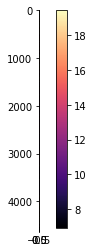

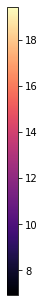

writing ply format


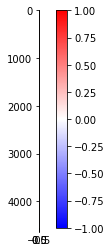

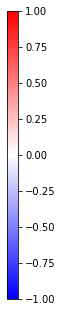

In [13]:
#m_i_myelin=morans_i(distMat, MyelinReduced, normalize=True, local=True, invert_dist=True)



#(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)




#for annotation in available_annotations():
    #test = fetch_annotation(source=annotation)
#    print(annotation)

    
# Myelin


annotation = fetch_annotation(source='xu2020',hemi='L',den='32k',desc='evoexp',return_single=True)

#annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='myelinmap',return_single=True)
annot_data=nib.load(annotation).agg_data()


sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
#Myelin_Is=morans_i(distMat, myelin[sIdx_red], normalize=True, local=True, invert_dist=True)




dataToDisplay=annot_data[sIdx_red]


# Normalize weights to sum up to 1 for each row





# Compute Local Moran's I for each spatial unit
I_values = m_i_myelin=morans_i(distMat, dataToDisplay, normalize=True, local=True, invert_dist=True)

nameToDisplay='xu2020'


cmap = matplotlib.cm.get_cmap('magma')

colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=dataToDisplay
DataRange=np.array([np.percentile(dataToDisplay,25),np.percentile(dataToDisplay,75)])
norm = matplotlib.colors.Normalize(vmin=DataRange[0], vmax=DataRange[1])
np.savetxt('SpatStatImages/DataRange_'+nameToDisplay+'.txt',DataRange)

CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/'+nameToDisplay + '.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(dataToDisplay.reshape(-1,1), cmap='magma',vmin=DataRange[0], vmax=DataRange[1])
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/Colorbar' + nameToDisplay+'.png', bbox_inches='tight')

plt.show()


cmap = matplotlib.cm.get_cmap('bwr')
colors=np.zeros([len(vertsFull)])
colors[SurfaceMask[:5000]==1]=I_values
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
CMap=cmap(norm(colors))*255

write_plyRGB('SpatStatImages/localMI_'+nameToDisplay+'.ply',vertsFull,facesFull,CMap[:,0],CMap[:,1],CMap[:,2])

fig, ax = plt.subplots()

cax = ax.imshow(I_values.reshape(-1,1), cmap='bwr',vmin=-1, vmax=1)
colorbar = plt.colorbar(cax)

colorbar_fig = plt.figure()
colorbar_ax = colorbar_fig.add_axes([0, 0, 0.025, 1])

# Add the colorbar to the new figure
colorbar = plt.colorbar(cax, cax=colorbar_ax)

# Save the colorbar as an image
colorbar_fig.savefig('SpatStatImages/MoransIColorBar.png', bbox_inches='tight')








In [ ]:
# Illustrating local Moran's I for two vertices on T1/T2 ratio map.

import matplotlib.pyplot as plt
import numpy as np

# Assuming MyelinReduced and distMat are defined elsewhere in your code

ind1 = 590
ind2 = 2040


MyelinReduced2=(MyelinReduced-np.mean(MyelinReduced))/np.std(MyelinReduced)

DiffsInd1 = MyelinReduced2[ind1] - MyelinReduced2
DiffsInd2 = MyelinReduced2[ind2] - MyelinReduced2

DiffsInd1=np.abs(DiffsInd1)
DiffsInd2=np.abs(DiffsInd2)

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

axs[1].scatter(distMat[ind1, :], DiffsInd1, s=1, c=[0.8, 0.2, 0], marker='s')
axs[0].scatter(distMat[ind2, :], DiffsInd2, s=1, c=[0.2, 0.8, 0], marker='s')

xmin1=0
xmax1=175
ymin1=0
ymax1=5
axs[0].set_xlim([xmin1, xmax1])
axs[0].set_ylim([ymin1, ymax1])
axs[1].set_xlim([xmin1, xmax1])
axs[1].set_ylim([ymin1, ymax1])
# Removing axis titles
for ax in axs:
    ax.tick_params(axis='both', which='both', labelsize=12)
    ax.set_xticklabels(ax.get_xticks(), fontname='Arial')
    ax.set_yticklabels(ax.get_yticks(), fontname='Arial')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')

plt.savefig('LocanMoransIIllustration.png',dpi=600)
plt.show()

In [ ]:
# Principal Gradient 
grad=0
sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
prinFG_Is=morans_i(distMat, fcgradient[sIdx_red,grad], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=fcgradient[sIdx_red,grad],cmap='bwr',marker='.')
#im=ax.scatter(lvert_S[sIdx_red,0],lvert_S[sIdx_red,1],lvert_S[sIdx_red,2],c=fcgradient[sIdx_red,grad],cmap='bwr',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=prinFG_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)

plt.savefig('PrincipalGradientDis_SAC.png',dpi=300)
#cbar = fig.colorbar(im, ax=ax)


dict_keys(['midthickness', 'inflated', 'veryinflated', 'sphere', 'medial', 'sulc', 'vaavg'])


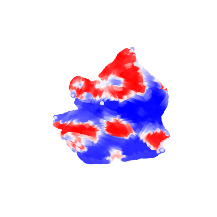

In [19]:
from neuromaps import datasets
from neuromaps.datasets import available_annotations,fetch_annotation
import numpy as np
import matplotlib.pyplot as plt

fslr = datasets.fetch_atlas(atlas='fslr', density='32k')
print(fslr.keys())

import nibabel as nib
#lsphere, rsphere = fslr['sphere']
ltemp, rtemp = fslr['sphere']
lvert_S, ltri_S = nib.load(ltemp).agg_data()
np.savetxt('ReducedSphericalXYZ.txt',lvert_S)
#HEREHERE
#print(lvert.shape, ltri.shape)

def appendSpherical_np(xyz):
# this function turns it from cartesian coordinates (x,y,z) into lontitude and latitude taken from https://pyquestions.com/faster-numpy-cartesian-to-spherical-coordinate-conversion
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:, 0]**2 + xyz[:, 1]**2
    ptsnew[:, 3] = np.sqrt(xy + xyz[:, 2]**2)
    ptsnew[:, 4] = np.arctan2(xyz[:, 2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:, 5] = np.arctan2(xyz[:, 1], xyz[:, 0])
    return ptsnew
ptsnew = appendSpherical_np(lvert_S) #Calculate haversine distance (i.e., approximate distance along the sphere's surface)

coords=np.rad2deg(ptsnew[:, 4:6])

np.savetxt('ReducedSphericalCoords.txt',coords)

fcgradient=np.zeros([lvert_S.shape[0],10])

for i in range(10):
    
    grad_name='fcgradient'+ str(i+1).zfill(2)
    annotation = fetch_annotation(source='margulies2016',hemi='L',den='32k',desc=grad_name,return_single=True)
    fcgradient[:,i]=nib.load(annotation).agg_data()
    
grad=0
#ltemp, rtemp = fslr['midthickness']
#lvert, ltri = nib.load(ltemp).agg_data()
gii = nib.load('/Users/robleech/Dropbox/HCP_S900_GroupAvg_v1/S900.L.flat.32k_fs_LR.surf.gii')

lvert=gii.agg_data()[0]
np.savetxt('FlatCoords.txt',lvert)
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[:,0],lvert[:,1],lvert[:,2],c=fcgradient[:,grad],cmap='bwr',marker='.')

np.savetxt('FlatFCGradient_0.txt',fcgradient[:,grad])
grad=1
np.savetxt('FlatFCGradient_0_1.txt',fcgradient[:,grad])
grad=2
np.savetxt('FlatFCGradient_0_2.txt',fcgradient[:,grad])
ax.view_init(elev=90, azim=0)


annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='myelinmap',return_single=True)
myelin=nib.load(annotation).agg_data()

np.savetxt('Myelin.txt',myelin)

annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='thickness',return_single=True)
thickness=nib.load(annotation).agg_data()

annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='thickness',return_single=True)
thickness=nib.load(annotation).agg_data()

np.savetxt('Thickness.txt',thickness)


(32492,)

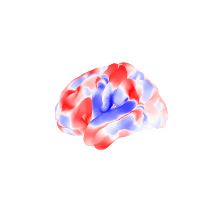

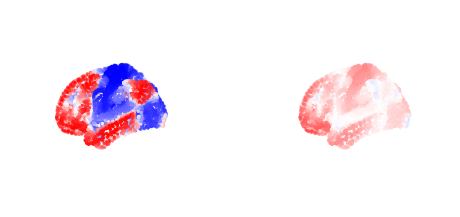

In [21]:
# Principal Gradient 
grad=0
sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
prinFG_Is=morans_i(distMat, fcgradient[sIdx_red,grad], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=fcgradient[sIdx_red,grad],cmap='bwr',marker='.')
#im=ax.scatter(lvert_S[sIdx_red,0],lvert_S[sIdx_red,1],lvert_S[sIdx_red,2],c=fcgradient[sIdx_red,grad],cmap='bwr',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=prinFG_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)

plt.savefig('PrincipalGradientDis_SAC.png',dpi=300)
#cbar = fig.colorbar(im, ax=ax)




/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_6412/3456644200.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('PrincipalGradientDis_SACSphDist.png',dpi=300,tranparent=True)


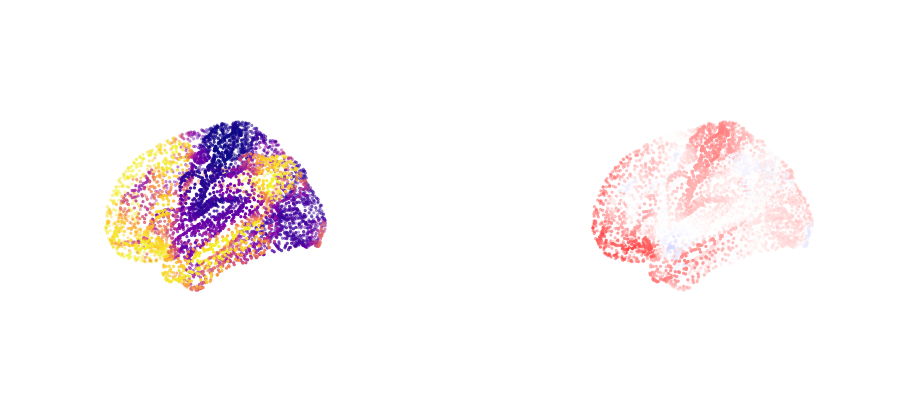

In [11]:
grad=0
sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]


lsphere, rsphere = fslr['sphere']
#lsphere, rsphere = fslr['midthickness']
lverts, ltris = nib.load(lsphere).agg_data()


ptsnew = appendSpherical_np(lverts[sIdx_red,:])
dist = DistanceMetric.get_metric('haversine') 
distMatSph = dist.pairwise(ptsnew[:, 4:6], ptsnew[:, 4:6]) # Surface distance matrix

prinFG_Is_sph=morans_i(distMatSph, fcgradient[sIdx_red,grad], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=fcgradient[sIdx_red,grad],cmap='plasma',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=prinFG_Is_sph,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)

plt.savefig('PrincipalGradientDis_SACSphDist.png',dpi=300,tranparent=True)
#cbar = fig.colorbar(im, ax=ax)




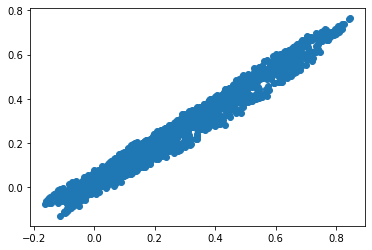

In [28]:
plt.scatter(prinFG_Is_sph,prinFG_Is)

In [11]:
# Myelin


annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='myelinmap',return_single=True)
myelin=nib.load(annotation).agg_data()


sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
Myelin_Is=morans_i(distMat, myelin[sIdx_red], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=myelin[sIdx_red],cmap='plasma',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=Myelin_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)

plt.savefig('MyelinDis_SAC.png',dpi=300,tranparent=True)
#cbar = fig.colorbar(im, ax=ax)

np.savetxt('Myelin.txt',myelin)



NameError: name 'SurfaceMask' is not defined

/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_6412/2043389938.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('ThicknessDis_SAC.png',dpi=300,tranparent=True)


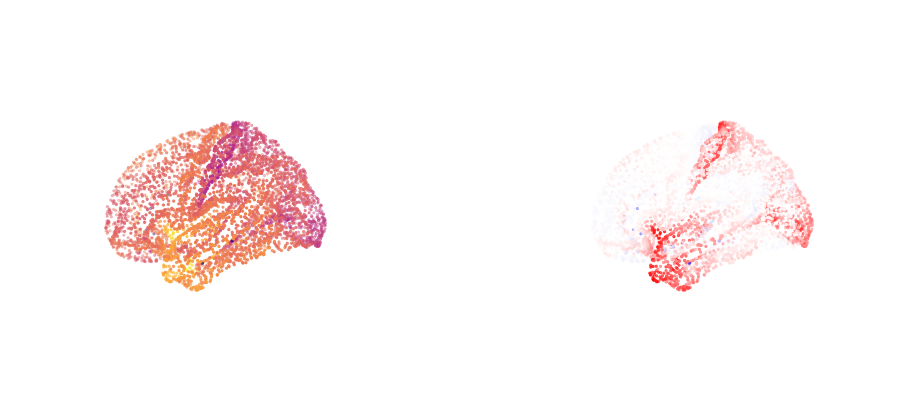

In [23]:
#  Thickness


annotation = fetch_annotation(source='hcps1200',hemi='L',den='32k',desc='thickness',return_single=True)
Thickness=nib.load(annotation).agg_data()


sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
Thick_Is=morans_i(distMat, Thickness[sIdx_red], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=Thickness[sIdx_red],cmap='plasma',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
ax.set_axis_off()
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=Thick_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)

plt.savefig('ThicknessDis_SAC.png',dpi=300,tranparent=True)
#cbar = fig.colorbar(im, ax=ax)

np.savetxt('ReducedSphericalThickness.txt',Thickness)






/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_6412/3912199709.py:17: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tranparent" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('XuEvoExpansion_SAC.png',dpi=300,tranparent=True)


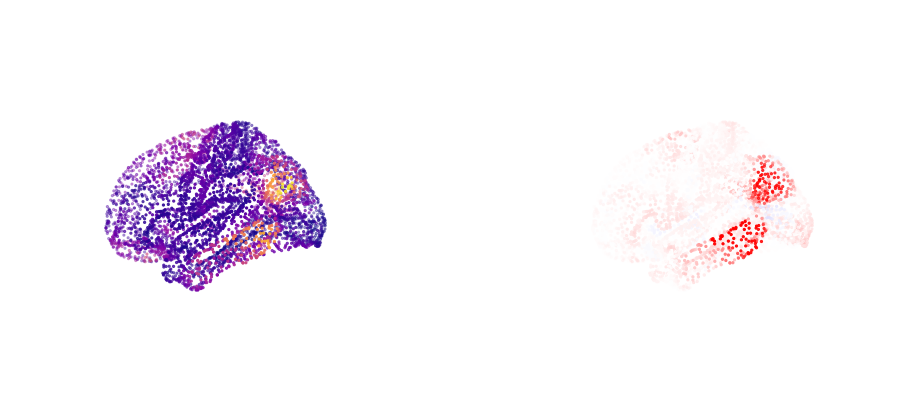

In [14]:


annotation = fetch_annotation(source='xu2020',hemi='L',den='32k',desc='evoexp',return_single=True)
evoexp=nib.load(annotation).agg_data()
sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
evoexp_Is=morans_i(distMat, evoexp[sIdx_red], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d')
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=evoexp[sIdx_red],cmap='plasma',marker='.')
ax.set_axis_off()
ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=evoexp_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)
ax.set_axis_off()
ax.view_init(elev=0, azim=180)
plt.savefig('XuEvoExpansion_SAC.png',dpi=300,tranparent=True)

#cbar = fig.colorbar(im, ax=ax)

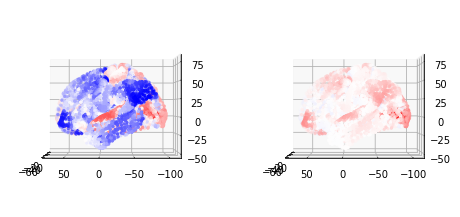

In [15]:


annotation = fetch_annotation(source='xu2020',hemi='L',den='32k',desc='FChomology',return_single=True)
FChomo=nib.load(annotation).agg_data()
sIdx=np.loadtxt('surfIdx.txt',dtype='int')-1
sIdx_red=sIdx[SurfaceMask[:5000]==1]
FChomo_Is=morans_i(distMat, FChomo[sIdx_red], normalize=True, local=True, invert_dist=True)
fig = plt.figure(figsize=(8,16))
ax = fig.add_subplot(121,projection='3d')
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=FChomo[sIdx_red],cmap='bwr',marker='.')

ax.view_init(elev=0, azim=180)
ax = fig.add_subplot(122,projection='3d')
#im=ax.scatter(verts[sIdx,0],verts[sIdx,1],verts[sIdx,2],c=results.localR2,cmap='rainbow',marker='.')
im=ax.scatter(lvert[sIdx_red,0],lvert[sIdx_red,1],lvert[sIdx_red,2],c=FChomo_Is,cmap='bwr',marker='.',vmin=-1,vmax=1)

ax.view_init(elev=0, azim=180)
plt.savefig('XuFCHomo_SAC.png',dpi=300)

#cbar = fig.colorbar(im, ax=ax)

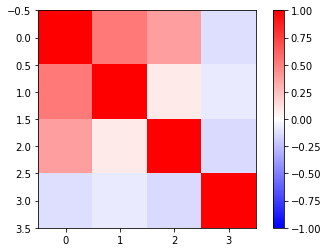

In [16]:
plt.imshow(np.corrcoef(np.vstack((Myelin_Is,Thick_Is,prinFG_Is_sph,evoexp_Is))),vmin=-1,vmax=1,cmap='bwr')
plt.colorbar()
plt.savefig('CorrMoransI_localMyThPGEE.png',dpi=300)